In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

🔹 Task 1: Custom State Teleportation

θ=0.39, φ=0.00


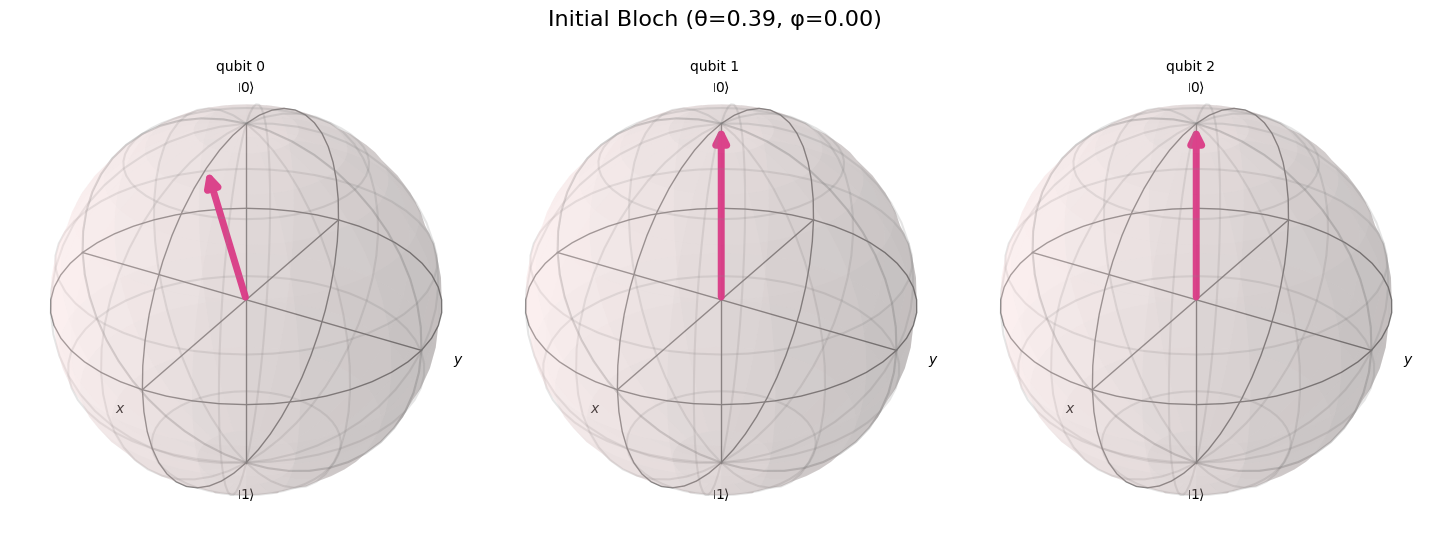

θ=0.79, φ=0.79


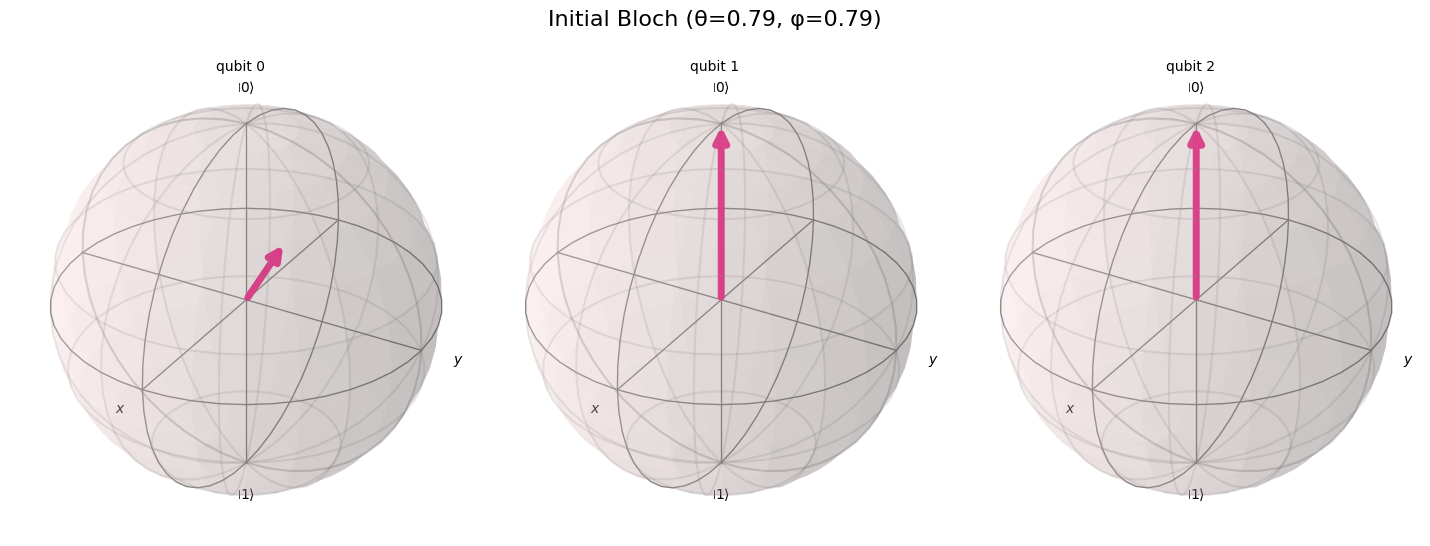

θ=1.57, φ=1.57


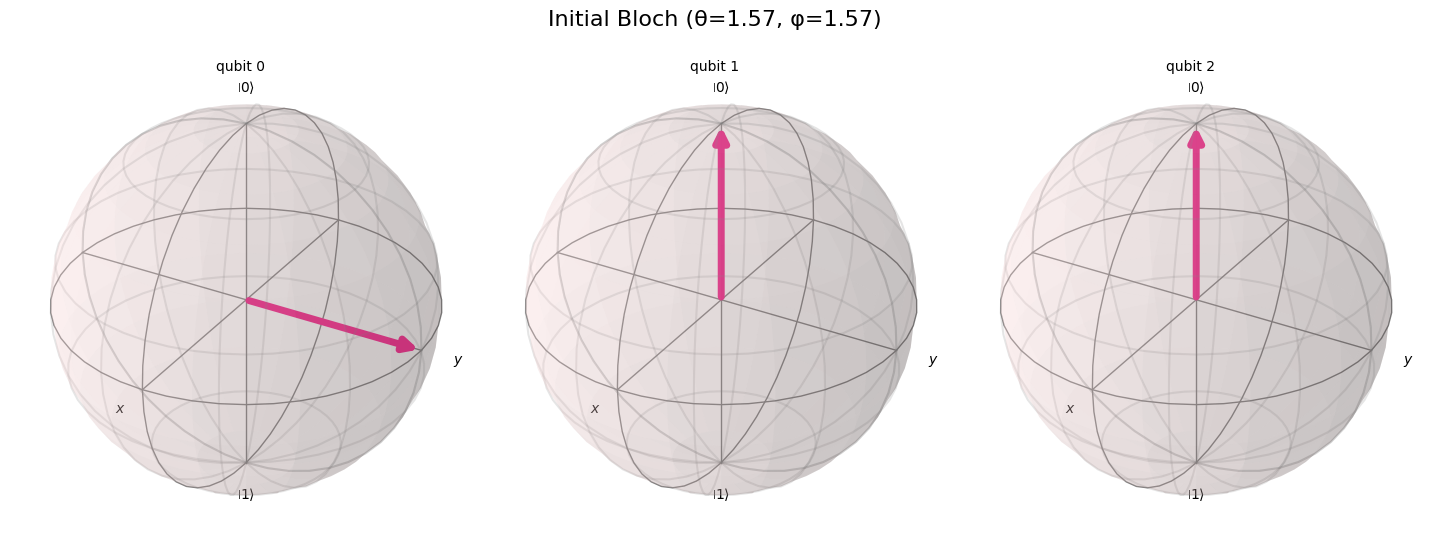

θ=3.14, φ=1.05


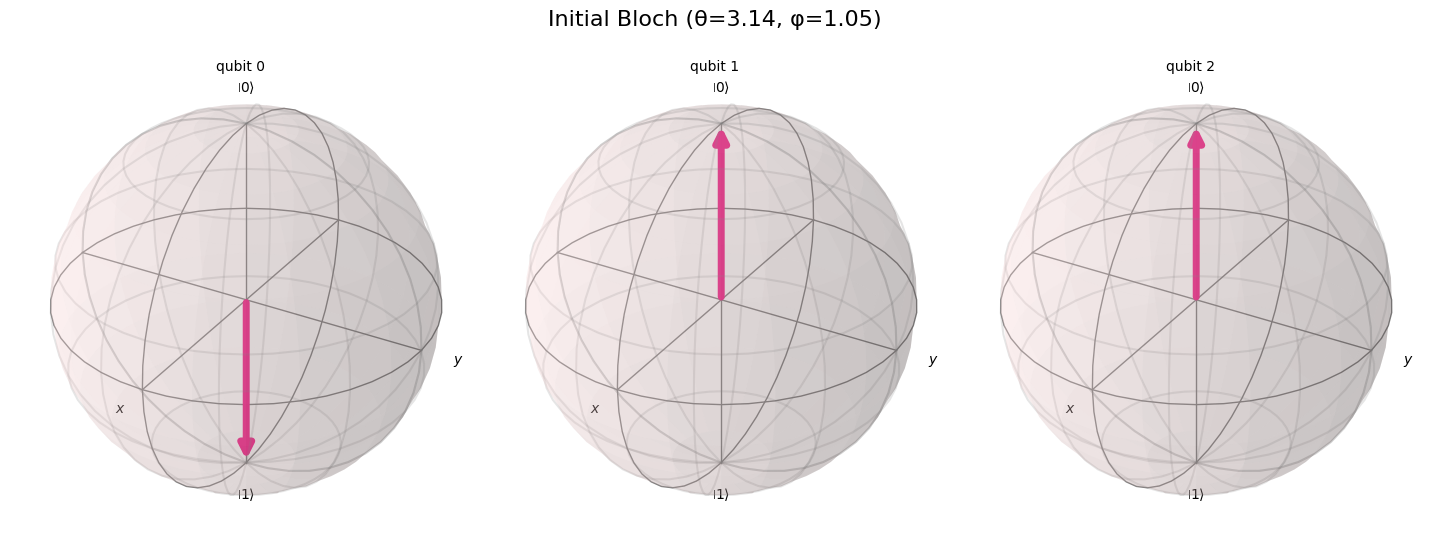

θ=3.77, φ=4.71


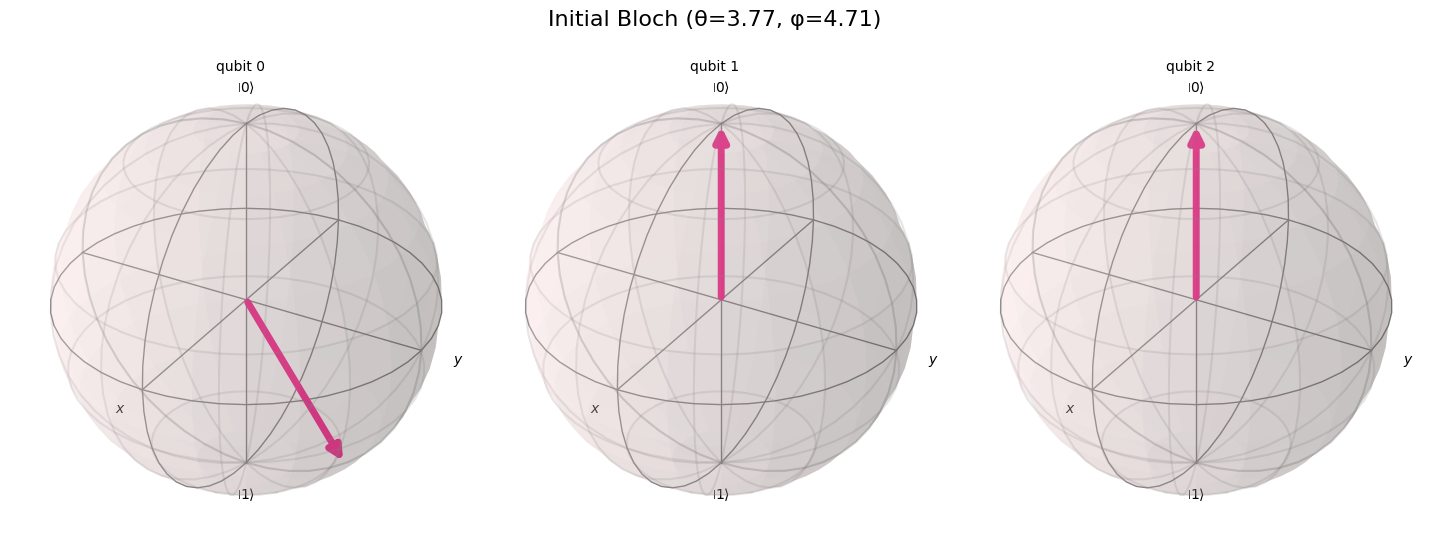


🔹 Task 2: Add Classical Measurement



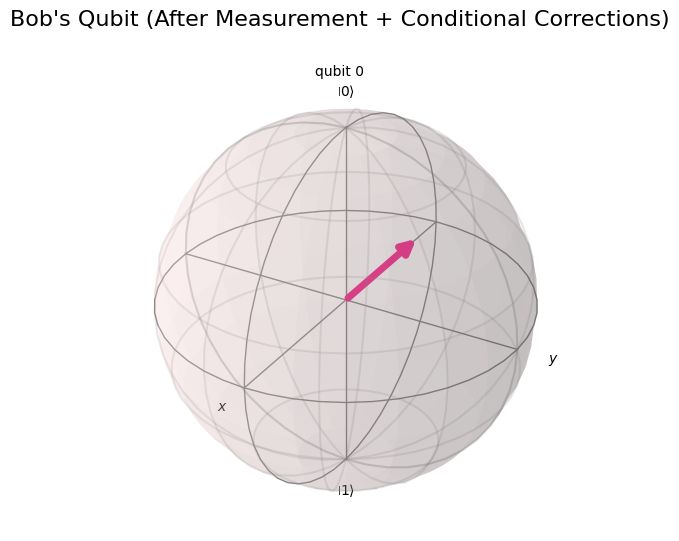


🔹 Task 3: Fidelity Analysis



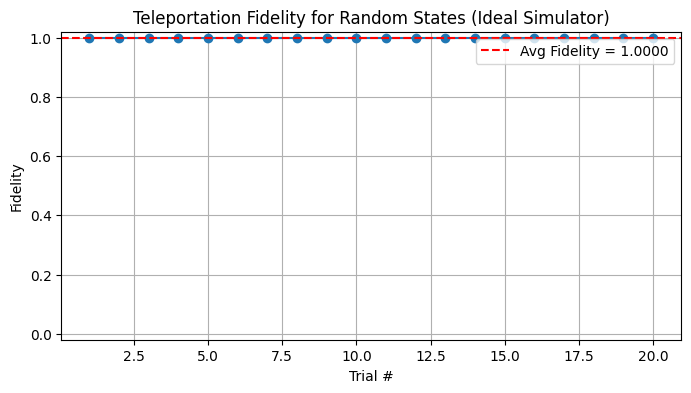

Average fidelity over 20 states: 1.000000

🔹 Task 4: Step-by-Step Visualization



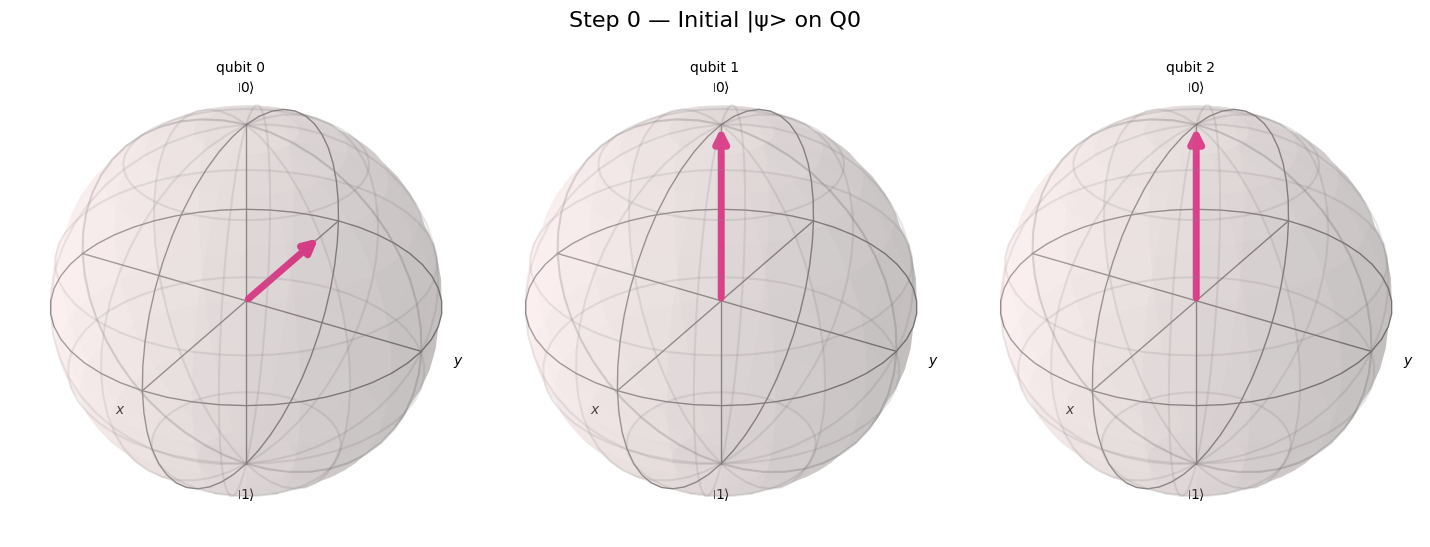

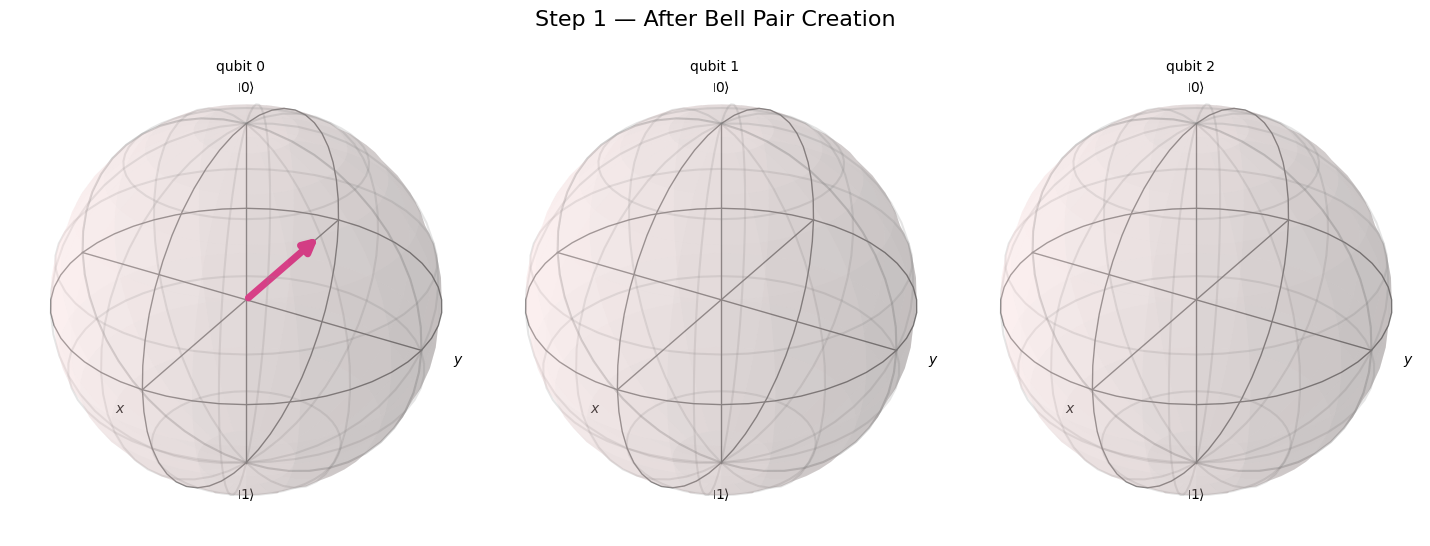

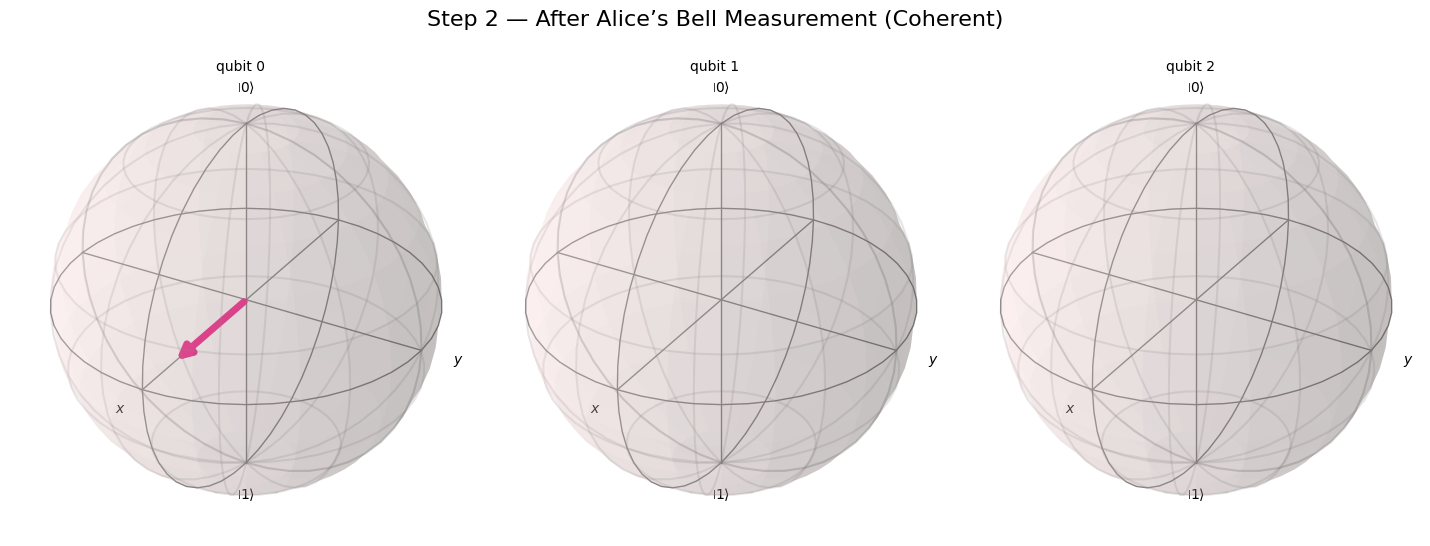

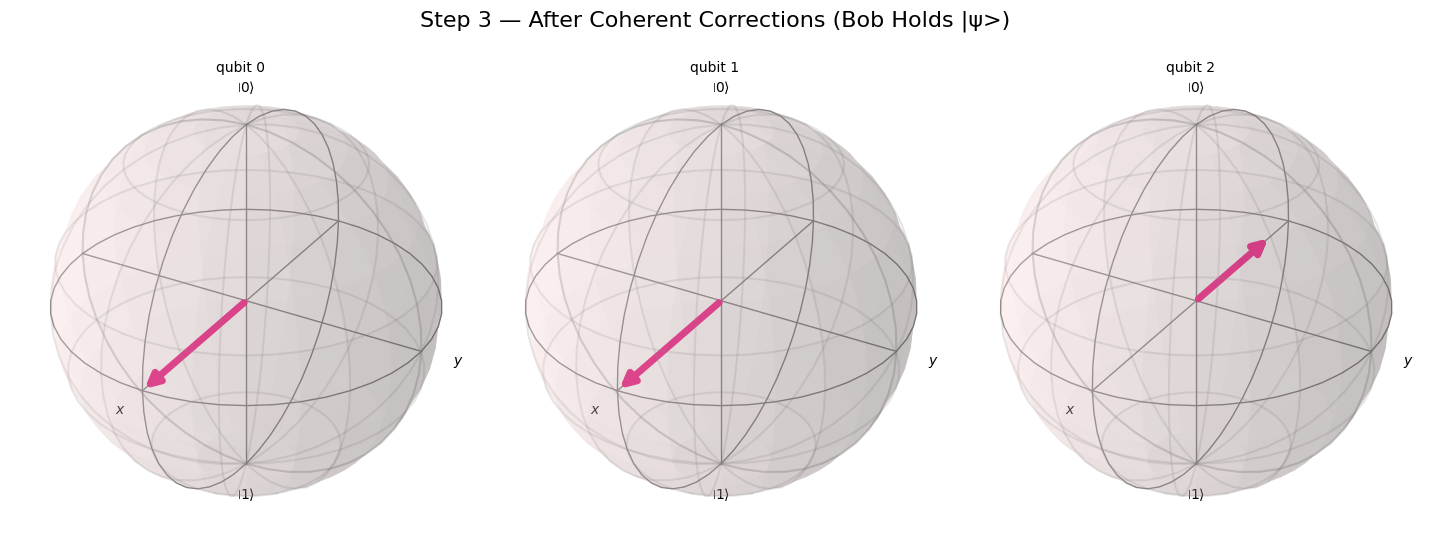

In [2]:

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# 🔹 Task 1: Custom State Teleportation (Vary θ, φ)
print("🔹 Task 1: Custom State Teleportation\n")

theta_phi_list = [
    (np.pi/8, 0.0),
    (np.pi/4, np.pi/4),
    (np.pi/2, np.pi/2),
    (np.pi, np.pi/3),
    (1.2*np.pi, 1.5*np.pi)
]

for theta, phi in theta_phi_list:
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv = Statevector.from_instruction(qc)
    print(f"θ={theta:.2f}, φ={phi:.2f}")
    display(plot_bloch_multivector(sv, title=f"Initial Bloch (θ={theta:.2f}, φ={phi:.2f})"))


# 🔹 Task 2: Add Classical Measurement (Realistic Teleportation)
print("\n🔹 Task 2: Add Classical Measurement\n")

qc = QuantumCircuit(3, 2)
theta, phi = np.pi/4, np.pi/3
qc.ry(theta, 0)
qc.rz(phi, 0)

qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.measure([0, 1], [0, 1])

# ✅ Conditional corrections (Qiskit 2.x style)
with qc.if_test((qc.clbits[1], 1)):
    qc.x(2)
with qc.if_test((qc.clbits[0], 1)):
    qc.z(2)

qc.save_statevector()
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = Statevector(result.data(0)["statevector"])
rho_bob = partial_trace(sv_final, [0, 1])
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
bob_sv = Statevector(bob_state)
display(plot_bloch_multivector(bob_sv, title="Bob's Qubit (After Measurement + Conditional Corrections)"))


# 🔹 Task 3: Fidelity Analysis (Multiple Random States)
print("\n🔹 Task 3: Fidelity Analysis\n")

def teleport_fidelity(theta, phi):
    qc = QuantumCircuit(3, 2)
    qc.ry(theta, 0)
    qc.rz(phi, 0)

    # Prepare the initial 1-qubit reference state correctly
    init_qc = QuantumCircuit(1)
    init_qc.ry(theta, 0)
    init_qc.rz(phi, 0)
    sv_init = Statevector.from_instruction(init_qc)

    # Entanglement and teleportation process
    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.measure([0, 1], [0, 1])
    with qc.if_test((qc.clbits[1], 1)):
        qc.x(2)
    with qc.if_test((qc.clbits[0], 1)):
        qc.z(2)
    qc.save_statevector()

    sim = AerSimulator()
    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()
    sv_final = Statevector(result.data(0)['statevector'])
    rho_bob = partial_trace(sv_final, [0, 1])
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
    return np.abs(np.vdot(sv_init.data, bob_state))**2

N = 20
fidelities = []
for i in range(N):
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2*np.pi)
    fidelities.append(teleport_fidelity(theta, phi))

plt.figure(figsize=(8,4))
plt.plot(range(1, N+1), fidelities, marker='o', linestyle='-')
plt.axhline(np.mean(fidelities), color='red', linestyle='--', label=f"Avg Fidelity = {np.mean(fidelities):.4f}")
plt.ylim(-0.02, 1.02)
plt.xlabel("Trial #")
plt.ylabel("Fidelity")
plt.title("Teleportation Fidelity for Random States (Ideal Simulator)")
plt.legend()
plt.grid(True)
plt.show()
print(f"Average fidelity over {N} states: {np.mean(fidelities):.6f}")


# ============================================================
# 🔹 Task 4: Step-by-Step Visualization (Bloch Spheres)
# ============================================================
print("\n🔹 Task 4: Step-by-Step Visualization\n")

qc = QuantumCircuit(3)
qc.ry(np.pi/4, 0)
qc.rz(np.pi/3, 0)
sv0 = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv0, title="Step 0 — Initial |ψ> on Q0"))

qc.h(1)
qc.cx(1, 2)
sv1 = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv1, title="Step 1 — After Bell Pair Creation"))

qc.cx(0, 1)
qc.h(0)
sv2 = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv2, title="Step 2 — After Alice’s Bell Measurement (Coherent)"))

qc.cx(1, 2)
qc.cz(0, 2)
sv3 = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv3, title="Step 3 — After Coherent Corrections (Bob Holds |ψ>)"))



In [3]:
# Task 5 — Introduce noise and observe fidelity degradation
!pip install qiskit qiskit_aer pylatexenc -q

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error  # ✅ Correct import for Qiskit 2.x
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np

# Create a simple depolarizing noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ['rz','ry','h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ['cx'])

# Use Aer simulator with noise
sim = AerSimulator(noise_model=noise_model)

# Prepare initial qubit
theta, phi = np.pi/4, np.pi/3
qc = QuantumCircuit(3)
qc.ry(theta, 0)
qc.rz(phi, 0)
sv_initial = Statevector.from_instruction(qc)

# Teleportation circuit (coherent)
qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.cx(1, 2)
qc.cz(0, 2)

# Save statevector and simulate
qc.save_statevector()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = Statevector(result.data(0)["statevector"])

# Compute fidelity
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]
fidelity = np.abs(np.vdot(init_state, bob_state))**2

print(f"Fidelity under noise = {fidelity:.6f}")


Fidelity under noise = 0.500000
